![image.png](https://towardsdatascience.com/wp-content/uploads/2024/05/1Qww2aaIdqrWVeNmo3AS0ZQ-2048x1314.png)




## Libraries

In [1]:
import torch
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM, AutoModelForCausalLM
import matplotlib.pyplot as plt
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
import math
import random

## Thermodynamic Length: in terms of model parameters (initial)

In [2]:
MODEL_NAME   = "microsoft/DialoGPT-medium"
MAX_SAMPLES  = 200            # use more for smoother estimates (e.g., 1k+)
BATCH_SIZE   = 2              # increase as memory allows
MAX_SEQ_LEN  = 256            # causal LM, full tokens; keep reasonable for GPU
NUM_WORKERS  = 2
DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
print(f"Using device: {DEVICE}")

Using device: cuda


In [4]:
SEED = 4242
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if DEVICE == "cuda":
    torch.cuda.manual_seed_all(SEED)

# GPU knobs
if DEVICE == "cuda":
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    try:
        torch.set_float32_matmul_precision("high")  # PyTorch 2.x
    except Exception:
        pass

In [5]:
print(f"Loading model: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

# GPT-2/DialoGPT has no pad token by default; set pad -> eos for batching
if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
model.eval().to(DEVICE)

# Convenience aliases for GPT-2 style modules
transformer   = model.transformer         # GPT2Model
blocks        = transformer.h             # list of Transformer blocks
final_ln      = transformer.ln_f          # final LayerNorm used before top head
lm_head       = model.lm_head             # tied to embeddings

num_layers = len(blocks)
print(f"Model has {num_layers} decoder blocks")

Loading model: microsoft/DialoGPT-medium


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/863M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/863M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Model has 24 decoder blocks


##### Datset used: SQuAD
Stanford Question Answering Dataset (SQuAD) is a reading comprehension dataset, consisting of questions posed by crowdworkers on a set of Wikipedia articles, where the answer to every question is a segment of text, or span, from the corresponding reading passage, or the question might be unanswerable.

SQuAD2.0 combines the 100,000 questions in SQuAD1.1 with over 50,000 unanswerable questions written adversarially by crowdworkers to look similar to answerable ones. To do well on SQuAD2.0, systems must not only answer questions when possible, but also determine when no answer is supported by the paragraph and abstain from answering.

In [6]:
print("Loading SQuAD (train)...")
ds = load_dataset("squad", split="train")

def build_text(example):
    q = example["question"].strip().replace("\n", " ")
    c = example["context"].strip().replace("\n", " ")
    # Prompt template — simple and consistent:
    return f"Question: {q}\nContext: {c}\nAnswer:"

ds = ds.map(lambda ex: {"text": build_text(ex)}, remove_columns=ds.column_names)

# Filter trivial/very short sequences
ds = ds.filter(lambda ex: len(ex["text"]) > 50)

if MAX_SAMPLES is not None:
    ds = ds.select(range(min(MAX_SAMPLES, len(ds))))

print(f"Dataset size after filtering/select: {len(ds)} rows")
print("\nSample prompt:")
print(ds[0]["text"][:400], " ...")

Loading SQuAD (train)...


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

plain_text/validation-00000-of-00001.par(…):   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Map:   0%|          | 0/87599 [00:00<?, ? examples/s]

Filter:   0%|          | 0/87599 [00:00<?, ? examples/s]

Dataset size after filtering/select: 200 rows

Sample prompt:
Question: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Context: Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basil  ...


In [7]:
# Collate: tokenize and build teacher-forced labels (shifted)
def causal_collate(batch):
    texts = [ex["text"] for ex in batch]
    tok = tokenizer(
        texts,
        padding="longest",
        truncation=True,
        max_length=MAX_SEQ_LEN,
        return_tensors="pt",
    )

    input_ids = tok["input_ids"]              # (B, S)
    attention_mask = tok["attention_mask"]    # (B, S)

    # Teacher forcing: predict next token
    # Shift: inputs[:-1], labels[1:]
    input_ids_shifted  = input_ids[:, :-1].contiguous()
    attention_shifted  = attention_mask[:, :-1].contiguous()
    labels_shifted     = input_ids[:, 1:].contiguous()

    # Ignore loss where the target token came from padding in the original sequence
    labels_shifted = labels_shifted.masked_fill(attention_mask[:, 1:] == 0, -100)

    batch = {
        "input_ids": input_ids_shifted,     # tokens up to second-to-last
        "labels": labels_shifted,           # next-token targets (pad -> -100)
        # We won’t use attention_mask in the blocks (causal mask handled internally),
        # but keep it for potential diagnostics:
        "attention_mask": attention_shifted,
    }
    return batch

loader = DataLoader(
    ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=causal_collate,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

In [8]:
'''Main computation
Strategy:
  1) Build initial embeddings once per batch: wte(input_ids) + wpe(pos_ids) -> drop
  2) For each layer ℓ:
       - Detach the incoming hidden state to isolate ℓ
       - Forward one block: h_ell = blocks[ℓ](h_prev)[0]
       - Logit lens: logits_ell = lm_head( ln_f( h_ell ) )
       - Cross-entropy loss (mean over non -100 positions)
  3) Sum all per-layer losses, single backward() to get all grads at once
  4) Accumulate ||grad||^2 over parameters of each block ℓ'''

layer_grad_sums = torch.zeros(num_layers, device=DEVICE)  # accumulate per-layer ||grad||^2
num_batches = 0

print("\nStarting per-layer effort computation (Observed Fisher style) ...")
amp_dtype = torch.bfloat16 if (DEVICE=="cuda" and torch.cuda.is_bf16_supported()) else torch.float16

for batch in tqdm(loader, total=math.ceil(len(ds)/BATCH_SIZE)):
    num_batches += 1

    input_ids = batch["input_ids"].to(DEVICE, non_blocking=True)   # (B, S-1)
    labels    = batch["labels"].to(DEVICE, non_blocking=True)      # (B, S-1)
    B, S = input_ids.shape

    # --- Build initial embeddings
    with torch.autocast(device_type="cuda", dtype=amp_dtype, enabled=(DEVICE=="cuda")):
        pos_ids = torch.arange(S, dtype=torch.long, device=DEVICE).unsqueeze(0).expand(B, S)
        h = transformer.wte(input_ids) + transformer.wpe(pos_ids)
        h = transformer.drop(h)

    # --- Per-layer losses
    per_layer_losses = []

    for ell in range(num_layers):
        h_prev = h.detach()  # <<< isolates gradients to block 'ell'

        with torch.autocast(device_type="cuda", dtype=amp_dtype, enabled=(DEVICE=="cuda")):
            # Forward one block;
            h_ell = blocks[ell](h_prev)[0]

            # Logit lens at layer ell:
            logits_ell = lm_head(final_ln(h_ell))

            # Cross-entropy on teacher-forced next-token targets
            loss_ell = F.cross_entropy(
                logits_ell.view(-1, logits_ell.size(-1)),
                labels.view(-1),
                ignore_index=-100,
                reduction="mean",
            )

        per_layer_losses.append(loss_ell)
        h = h_ell  # advance the hidden state for the next block

    # --- Single backward for all ℓ ---
    model.zero_grad(set_to_none=True)
    total_loss = torch.stack(per_layer_losses).sum()
    total_loss.backward()

    # --- Accumulate squared grad norms for each block's parameters ---
    with torch.no_grad():
        for ell in range(num_layers):
            g2 = torch.tensor(0.0, device=DEVICE)
            for p in blocks[ell].parameters():
                if p.grad is not None:
                    g2 += (p.grad.detach() ** 2).sum()
            layer_grad_sums[ell] += g2


Starting per-layer effort computation (Observed Fisher style) ...


100%|██████████| 100/100 [03:00<00:00,  1.80s/it]



--- Per-layer squared gradient norms (mean over batches) ---
Layer  1:  3.992427e+02
Layer  2:  1.468945e+02
Layer  3:  1.031877e+02
Layer  4:  6.752973e+01
Layer  5:  5.045254e+01
Layer  6:  2.885660e+01
Layer  7:  1.959774e+01
Layer  8:  1.350743e+01
Layer  9:  3.399373e+01
Layer 10:  5.494263e+01
Layer 11:  5.472042e+01
Layer 12:  4.202975e+01
Layer 13:  9.795194e+01
Layer 14:  7.596672e+01
Layer 15:  3.318478e+01
Layer 16:  3.653396e+01
Layer 17:  2.885680e+01
Layer 18:  2.995477e+01
Layer 19:  8.726003e+01
Layer 20:  6.032204e+01
Layer 21:  6.566399e+01
Layer 22:  3.132142e+01
Layer 23:  1.530250e+01
Layer 24:  5.202253e+00


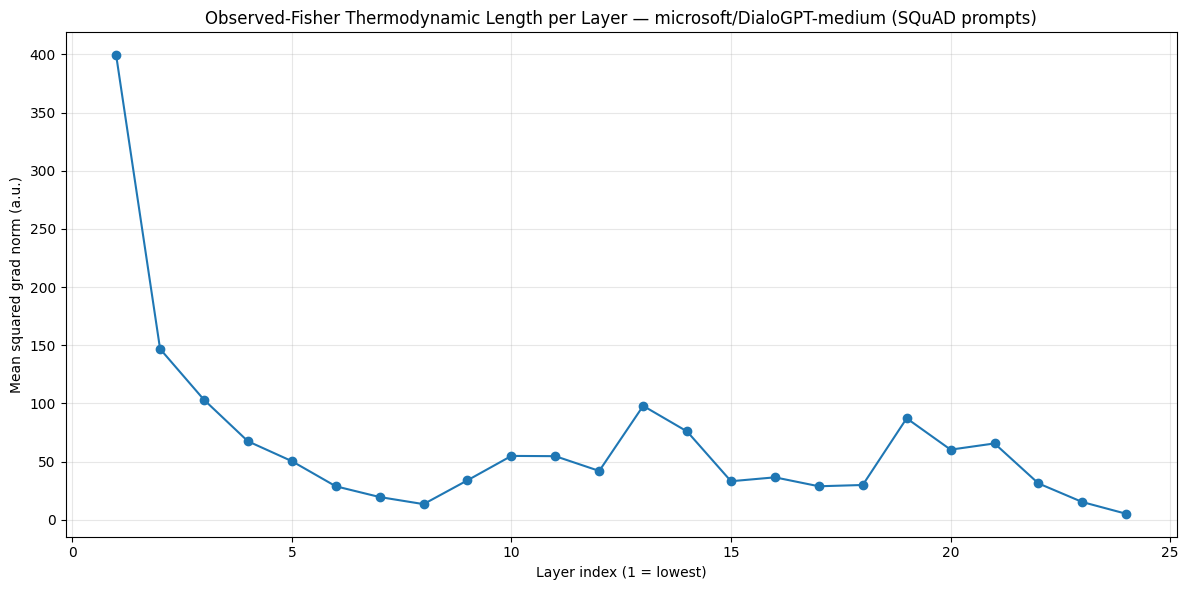

In [9]:
#Results

layer_grad_sums_cpu = layer_grad_sums.detach().cpu().numpy()
mean_layer_grad_sq = layer_grad_sums_cpu / max(1, num_batches)  # mean over batches

print("\n--- Per-layer squared gradient norms (mean over batches) ---")
for i, val in enumerate(mean_layer_grad_sq, start=1):
    print(f"Layer {i:2d}: {val: .6e}")

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(range(1, num_layers+1), mean_layer_grad_sq, marker='o')
plt.title(f'Observed-Fisher Thermodynamic Length per Layer — {MODEL_NAME} (SQuAD prompts)')
plt.xlabel('Layer index (1 = lowest)')
plt.ylabel('Mean squared grad norm (a.u.)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Thermodynamic Length: in terms of model predictions (revised) -- The Logit–Simplex Fisher–Rao method


Computing Thermodynamic Length from predictions (Fisher–Rao, exact) ...


100%|██████████| 100/100 [01:05<00:00,  1.52it/s]



--- Fisher–Rao Thermodynamic Length from predictions (per inter-layer step) ---
Between layers  1 and  2: 1.114033e+00 rad
Between layers  2 and  3: 9.349279e-01 rad
Between layers  3 and  4: 7.830067e-01 rad
Between layers  4 and  5: 8.869028e-01 rad
Between layers  5 and  6: 8.242082e-01 rad
Between layers  6 and  7: 7.426243e-01 rad
Between layers  7 and  8: 7.661914e-01 rad
Between layers  8 and  9: 1.152593e+00 rad
Between layers  9 and 10: 9.673551e-01 rad
Between layers 10 and 11: 6.738328e-01 rad
Between layers 11 and 12: 6.544784e-01 rad
Between layers 12 and 13: 8.701219e-01 rad
Between layers 13 and 14: 5.251812e-01 rad
Between layers 14 and 15: 6.041710e-01 rad
Between layers 15 and 16: 5.350522e-01 rad
Between layers 16 and 17: 5.178429e-01 rad
Between layers 17 and 18: 4.953289e-01 rad
Between layers 18 and 19: 5.016868e-01 rad
Between layers 19 and 20: 4.994725e-01 rad
Between layers 20 and 21: 4.750937e-01 rad
Between layers 21 and 22: 4.798741e-01 rad
Between layers 2

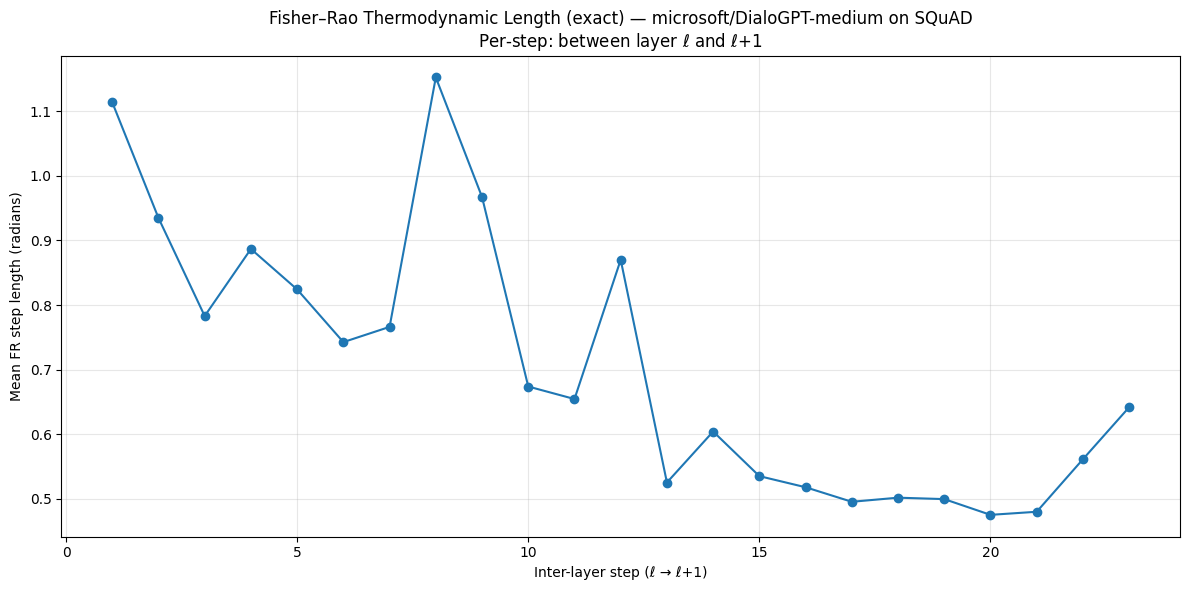

In [10]:
# Accumulators for per-step (between layers) mean FR length
# step k corresponds to "between block k and k+1" → there are (num_layers-1) steps
num_steps = len(blocks) - 1
fr_step_sums   = torch.zeros(num_steps, device=DEVICE)  # sum of FR lengths over valid tokens
fr_step_counts = torch.zeros(num_steps, device=DEVICE)  # count of valid tokens

print("\nComputing Thermodynamic Length from predictions (Fisher–Rao, exact) ...")

@torch.no_grad()
def fr_step_from_logprobs(logp_prev, logp_next, valid_mask):
    """
    logp_prev, logp_next: (B, S, V) log-probabilities for adjacent layers (already log_softmaxed, float32)
    valid_mask:          (B, S) boolean mask for positions with labels != -100

    Returns:
      step_lengths: (B, S) = 2 * arccos( sum_i sqrt(p_prev_i * p_next_i) )
    Numerically stable via log-sum-exp on 0.5*(logp_prev + logp_next).
    """
    # s = 0.5*(logp_prev + logp_next);    BC = sum_i exp(s_i)
    s = 0.5 * (logp_prev + logp_next)                      # (B, S, V)
    log_bc = torch.logsumexp(s, dim=-1)                    # (B, S)
    bc = torch.exp(log_bc)                                 # (B, S), Bhattacharyya coefficient in [0, 1] (numerically may creep outside)
    bc = bc.clamp_(0.0, 1.0)
    steps = 2.0 * torch.acos(bc)                           # (B, S), exact FR step between the two distributions
    if valid_mask is not None:
        steps = steps.masked_fill(~valid_mask, 0.0)
    return steps

# Iterate over SQuAD batches again (teacher-forced)
for batch in tqdm(loader, total=math.ceil(len(loader.dataset)/loader.batch_size)):
    input_ids = batch["input_ids"].to(DEVICE, non_blocking=True)   # (B, S-1)
    labels    = batch["labels"].to(DEVICE, non_blocking=True)      # (B, S-1)
    B, S = input_ids.shape

    # Build initial hidden state exactly as before
    with torch.autocast(device_type="cuda", dtype=amp_dtype, enabled=(DEVICE=="cuda")):
        pos_ids = torch.arange(S, dtype=torch.long, device=DEVICE).unsqueeze(0).expand(B, S)
        h = transformer.wte(input_ids) + transformer.wpe(pos_ids)
        h = transformer.drop(h)

    # We will carry log-probs from the previous layer to compute FR step with the current one
    logp_prev = None

    for ell in range(len(blocks)):
        h = blocks[ell](h)[0]  # forward one block

        # "Logit lens": apply the same final LN + lm_head used at the top
        with torch.autocast(device_type="cuda", dtype=amp_dtype, enabled=(DEVICE=="cuda")):
            logits = lm_head(final_ln(h))                 # (B, S, V)

        # Work in float32 for log-softmax stability
        logp = F.log_softmax(logits.float(), dim=-1)      # (B, S, V), log p^{(ℓ)}

        if logp_prev is not None:
            # Valid positions are exactly where we have a next-token target (labels != -100)
            valid = (labels != -100)                      # (B, S)

            # Exact FR step length between consecutive layers at each position t
            steps = fr_step_from_logprobs(logp_prev, logp, valid)   # (B, S)

            step_idx = ell - 1  # "between block ell-1 and ell"
            fr_step_sums[step_idx]   += steps.sum()
            fr_step_counts[step_idx] += valid.sum()

        logp_prev = logp  # slide window

# Compute mean FR length per inter-layer step
fr_step_means = (fr_step_sums / fr_step_counts.clamp_min(1)).detach().cpu().numpy()

# ----- Report -----
print("\n--- Fisher–Rao Thermodynamic Length from predictions (per inter-layer step) ---")
for k, val in enumerate(fr_step_means, start=1):
    print(f"Between layers {k:2d} and {k+1:2d}: {val:.6e} rad")

# Plot profile across depth
plt.figure(figsize=(12, 6))
x = np.arange(1, num_steps+1)
plt.plot(x, fr_step_means, marker='o')
plt.title(f'Fisher–Rao Thermodynamic Length (exact) — {MODEL_NAME} on SQuAD\n'
          f'Per-step: between layer $\\ell$ and $\\ell{{+}}1$')
plt.xlabel('Inter-layer step (ℓ → ℓ+1)')
plt.ylabel('Mean FR step length (radians)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Merge: The Semantic Efficiency

Data successfully aligned. Using parameter strain from layers 1 to 23.
Original Parameter Strain data length: 24
Matched Parameter Strain data length: 23
Belief Change data length: 23

--- Final Metrics ---
Layer |   Param Strain (E_l) |   Belief Change (Δp_l) |  Semantic Efficiency (L_eff)
-------------------------------------------------------------------------------------
    1 |           3.9924e+02 |           1.114033e+00 |                       0.6643
    2 |           1.4689e+02 |           9.349279e-01 |                       1.0861
    3 |           1.0319e+02 |           7.830067e-01 |                       1.0834
    4 |           6.7530e+01 |           8.869028e-01 |                       1.6753
    5 |           5.0453e+01 |           8.242082e-01 |                       1.8532
    6 |           2.8857e+01 |           7.426243e-01 |                       2.3909
    7 |           1.9598e+01 |           7.661914e-01 |                       3.3398
    8 |           1.3507e+0

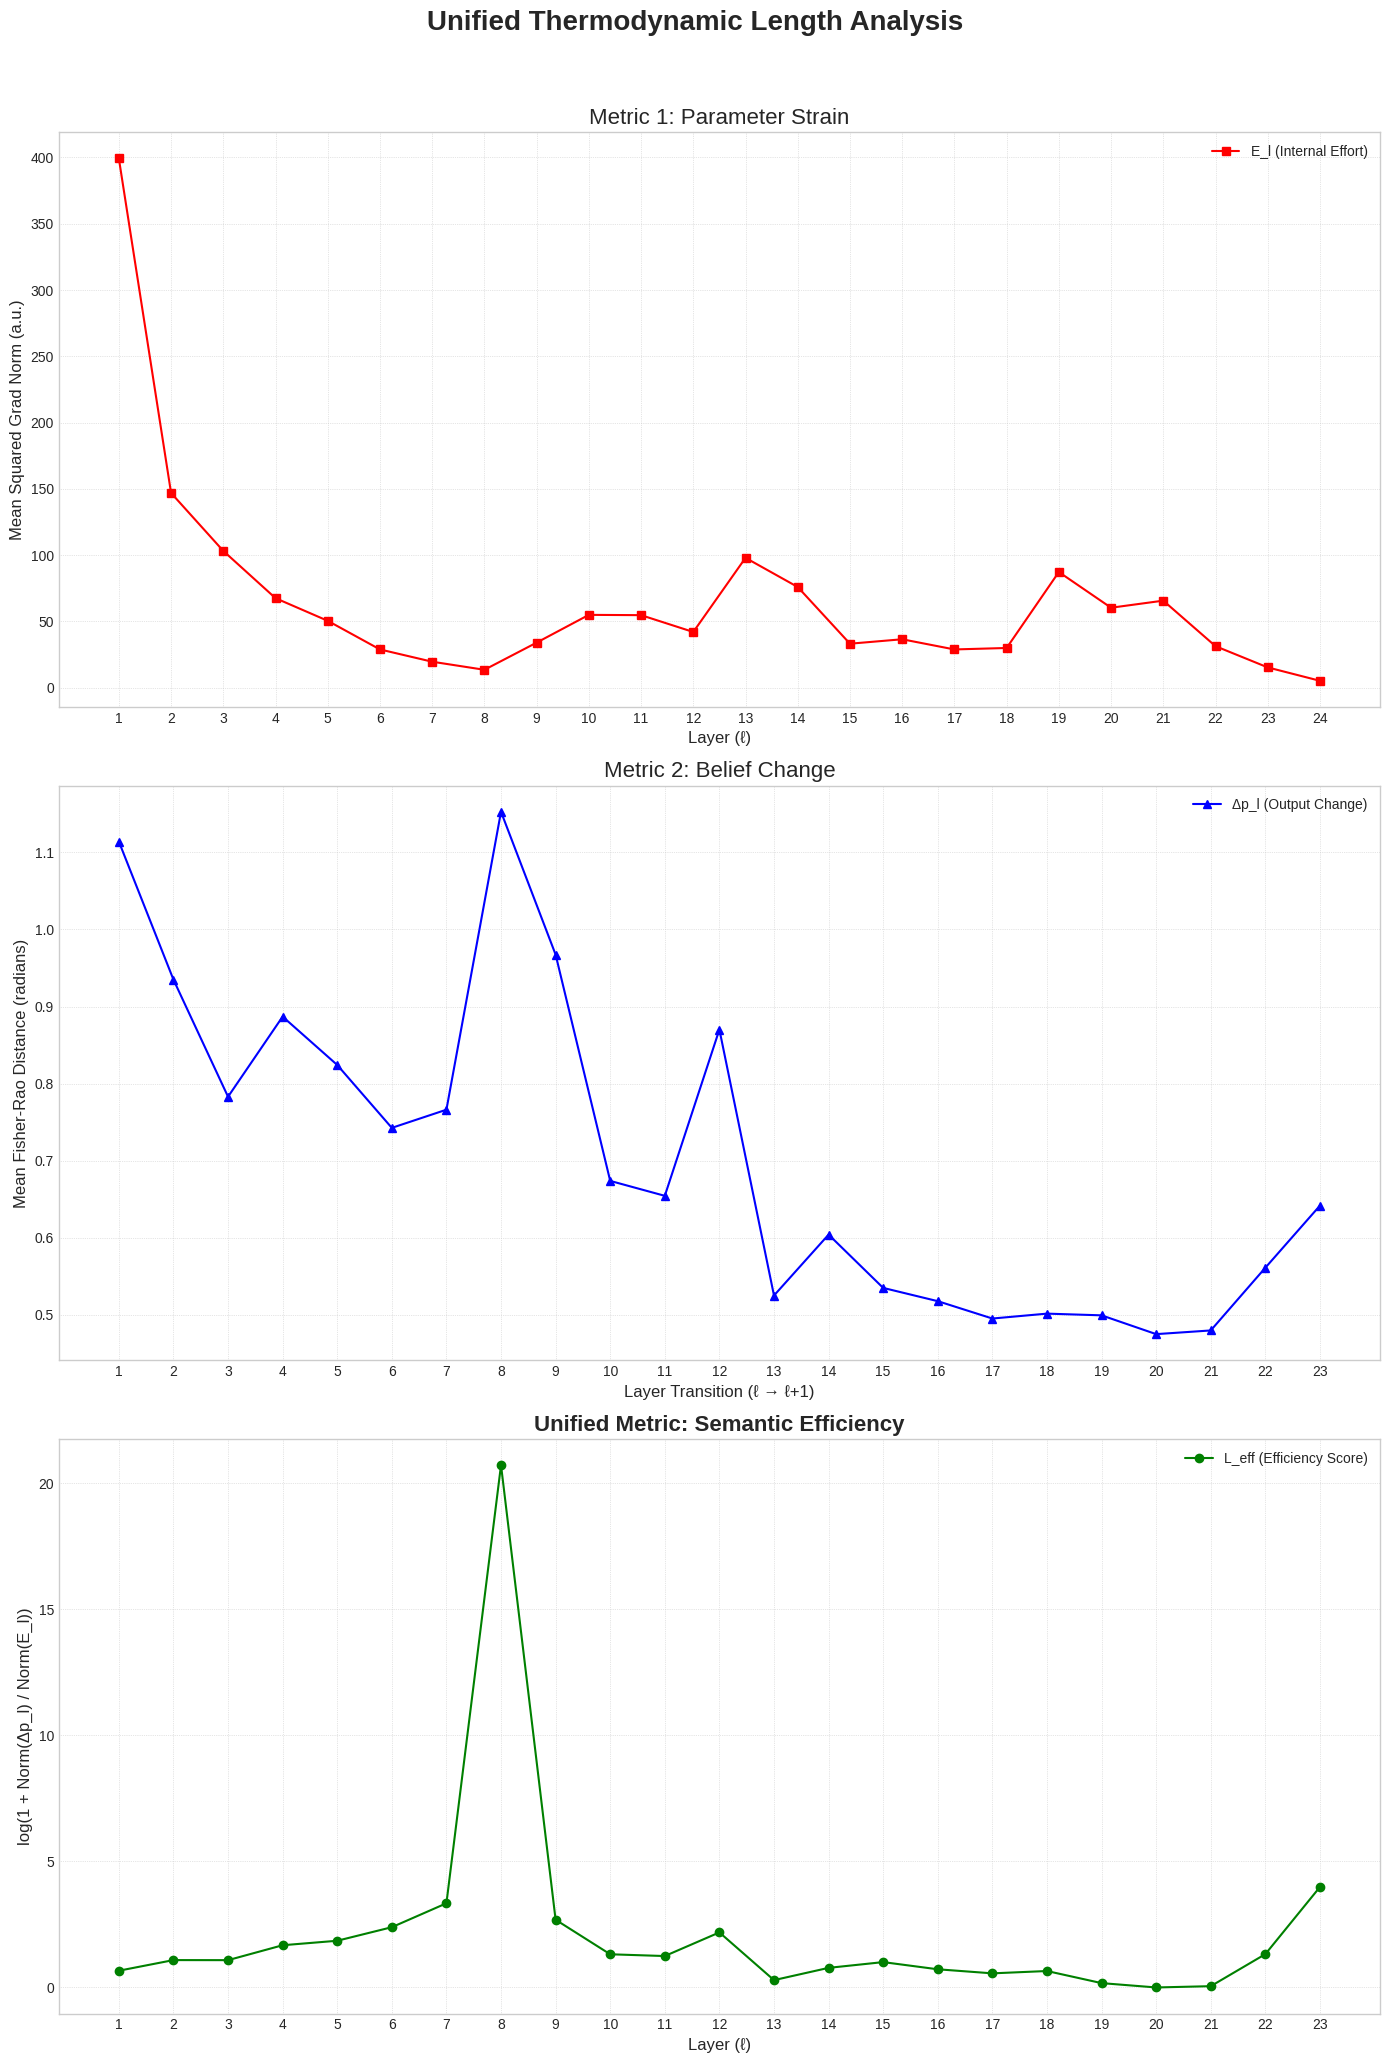

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# ==============================================================================
# Step 1: Input the Raw Data
# ==============================================================================
# As you noted, the first list corresponds to Belief Change (Δp_l)
# and the second to Parameter Strain (E_l).

# Data for Δp_l: Fisher-Rao distance between consecutive layers (23 values)
raw_belief_change = np.array([
    1.114033e+00, 9.349279e-01, 7.830067e-01, 8.869028e-01, 8.242082e-01,
    7.426243e-01, 7.661914e-01, 1.152593e+00, 9.673551e-01, 6.738328e-01,
    6.544784e-01, 8.701219e-01, 5.251812e-01, 6.041710e-01, 5.350522e-01,
    5.178429e-01, 4.953289e-01, 5.016868e-01, 4.994725e-01, 4.750937e-01,
    4.798741e-01, 5.612271e-01, 6.417844e-01
])

# Data for E_l: Mean squared gradient norm at each layer (24 values)
raw_param_strain = np.array([
    3.992427e+02, 1.468945e+02, 1.031877e+02, 6.752973e+01, 5.045254e+01,
    2.885660e+01, 1.959774e+01, 1.350743e+01, 3.399373e+01, 5.494263e+01,
    5.472042e+01, 4.202975e+01, 9.795194e+01, 7.596672e+01, 3.318478e+01,
    3.653396e+01, 2.885680e+01, 2.995477e+01, 8.726003e+01, 6.032204e+01,
    6.566399e+01, 3.132142e+01, 1.530250e+01, 5.202253e+00
])

EPSILON = 1e-9 # Small constant for numerical stability

# ==============================================================================
# Step 2: Handle Mismatched Array Sizes
# ==============================================================================
# The belief change Δp_l happens between layer l and l+1.
# The parameter strain E_l happens AT layer l.
# To calculate the ratio Δp_l / E_l, we pair the change from l->l+1 with the
# strain at layer l. This means we only need the first 23 values of parameter strain.
param_strain_matched = raw_param_strain[:23]

print("Data successfully aligned. Using parameter strain from layers 1 to 23.")
print(f"Original Parameter Strain data length: {len(raw_param_strain)}")
print(f"Matched Parameter Strain data length: {len(param_strain_matched)}")
print(f"Belief Change data length: {len(raw_belief_change)}")


# ==============================================================================
# Step 3: Normalize Both Metrics to a [0, 1] Range
# ==============================================================================
# Normalization is crucial because the raw scales are vastly different.
# This makes their ratio meaningful.
def min_max_scale(x):
    """Scales a numpy array to the [0, 1] range."""
    return (x - x.min()) / (x.max() - x.min() + EPSILON)

norm_param_strain = min_max_scale(param_strain_matched)
norm_belief_change = min_max_scale(raw_belief_change)

# ==============================================================================
# Step 4: Calculate the Final "Semantic Efficiency"
# ==============================================================================
# Formula: L_eff(l) = log(1 + Δp_l_norm / (E_l_norm + ε))
semantic_efficiency = np.log(1 + norm_belief_change / (norm_param_strain + EPSILON))


# ==============================================================================
# Step 5: Report and Plot the Results
# ==============================================================================
print("\n--- Final Metrics ---")
print(f"{'Layer':>5} | {'Param Strain (E_l)':>20} | {'Belief Change (Δp_l)':>22} | {'Semantic Efficiency (L_eff)':>28}")
print("-" * 85)
for i in range(len(semantic_efficiency)):
    print(f"{i+1:>5} | {param_strain_matched[i]:>20.4e} | {raw_belief_change[i]:>22.6e} | {semantic_efficiency[i]:>28.4f}")

# Create a comprehensive 3-panel plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(3, 1, figsize=(14, 21), sharex=False)
fig.suptitle('Unified Thermodynamic Length Analysis', fontsize=20, fontweight='bold')

# --- Plot 1: Parameter Strain (E_l) ---
layer_indices_strain = range(1, len(raw_param_strain) + 1)
axes[0].plot(layer_indices_strain, raw_param_strain, marker='s', color='red', label='E_l (Internal Effort)')
axes[0].set_title('Metric 1: Parameter Strain', fontsize=16)
axes[0].set_ylabel('Mean Squared Grad Norm (a.u.)', fontsize=12)
axes[0].set_xlabel('Layer (ℓ)', fontsize=12)
axes[0].set_xticks(layer_indices_strain)
axes[0].legend()
axes[0].grid(True, which='both', linestyle=':', linewidth=0.5)

# --- Plot 2: Belief Change (Δp_l) ---
layer_indices_change = range(1, len(raw_belief_change) + 1)
axes[1].plot(layer_indices_change, raw_belief_change, marker='^', color='blue', label='Δp_l (Output Change)')
axes[1].set_title('Metric 2: Belief Change', fontsize=16)
axes[1].set_ylabel('Mean Fisher-Rao Distance (radians)', fontsize=12)
axes[1].set_xlabel('Layer Transition (ℓ → ℓ+1)', fontsize=12)
axes[1].set_xticks(layer_indices_change)
axes[1].legend()
axes[1].grid(True, which='both', linestyle=':', linewidth=0.5)

# --- Plot 3: Semantic Efficiency (L_eff) ---
layer_indices_eff = range(1, len(semantic_efficiency) + 1)
axes[2].plot(layer_indices_eff, semantic_efficiency, marker='o', color='green', label='L_eff (Efficiency Score)')
axes[2].set_title('Unified Metric: Semantic Efficiency', fontsize=16, fontweight='bold')
axes[2].set_ylabel('log(1 + Norm(Δp_l) / Norm(E_l))', fontsize=12)
axes[2].set_xlabel('Layer (ℓ)', fontsize=12)
axes[2].set_xticks(layer_indices_eff)
axes[2].legend()
axes[2].grid(True, which='both', linestyle=':', linewidth=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()